# BM4H

This is a notebook to try something like what they did in [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb).

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

In [2]:
%matplotlib inline

## Making data

Just to get things started, I'm going to construct two series of data.
Each of these series will be sampled from a respective Poisson distribution, each with different rate, $\lambda$.
The two datasets will then be spliced together.

In [3]:
# Constants
RATE_A = 10
RATE_B = 50
LENGTH_A = 50
LENGTH_B = 50

In [4]:
# Derived values
START_A = 0
END_A = START_A + LENGTH_A
START_B = LENGTH_A
END_B = START_B + LENGTH_B

In [5]:
def generate_data(rate, start, end):
    """
    A function to generate some data based on a Poisson distribution.
    Params:
        rate: the rate, lambda for the Poisson distribution.
        start: the start point for the data.
        end: the end point for the data.
    Returns:
        dataframe: a dat array of Poisson distributed samples.
    """
    data = pd.DataFrame()
    data['day'] = np.arange(start, end)
    data['vals'] = np.random.poisson(rate, end-start)
    return data

In [6]:
part_a = generate_data(RATE_A, START_A, END_A)

In [7]:
def plot_data(data):
    """
    A quick function to plot the data with the appropriate labels.
    """
    plt.figure(figsize=(8,8))
    plt.bar(data['day'], data['vals'])
    plt.xlabel('day')
    plt.ylabel('value')
    plt.show()

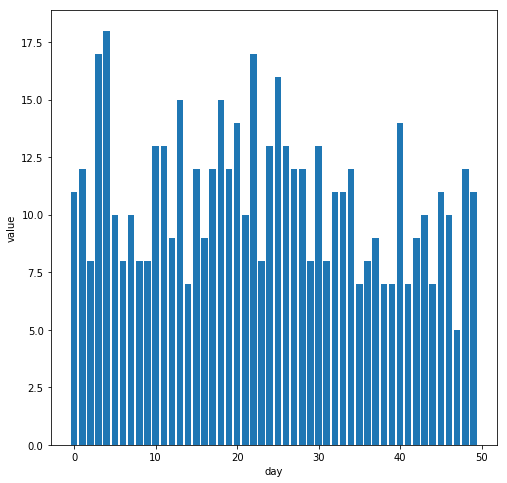

In [8]:
plot_data(part_a)

In [9]:
part_b = generate_data(RATE_B, START_B, END_B)

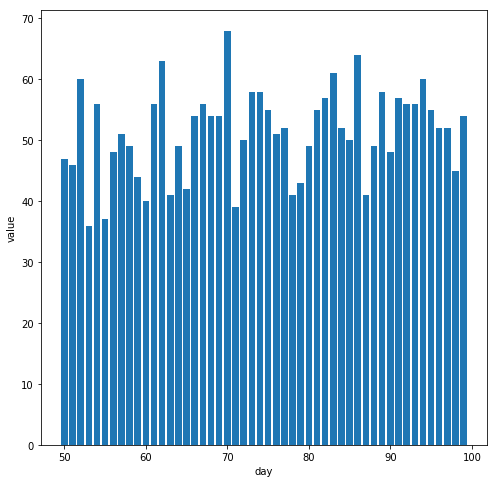

In [10]:
plot_data(part_b)

In [11]:
data = pd.concat([part_a, part_b])

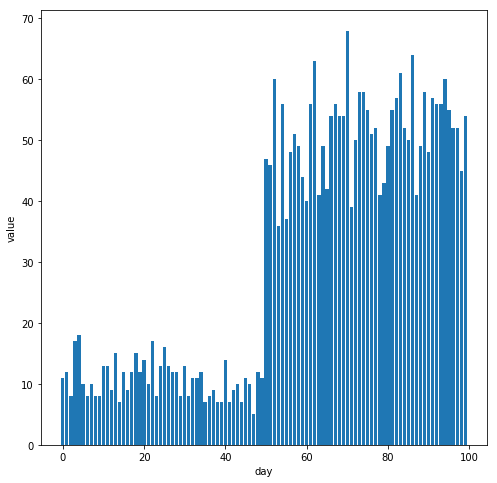

In [12]:
plot_data(data)

Ok, so it looks like we've got some data here.
Hopefully, it is clear that there are two separate behaviours going on.
Now we'd like to see if we can get the computer to identify this too.

## Modelling

In modelling terms, we know ourselves that for $0 \leq d \leq 50$ there is a lower rate of $\lambda_1 = 10$, and that for $50 \leq d \leq 100$ there is a higher rate of $\lambda_2 = 50$ - we want to see if we can automate the process by which we identify $\lambda_1$ and $\lambda_2$, and furthermore identify  the time, $\tau = 50$, at which this change happens.

The plan, therefore, is to infer from the data, what the values of $\lambda_1$, $\lambda_2$ and $\tau$ are.
To do this under a Bayesian framework, we need to prescribe prior probabilities to each of them.

Let us start of with an educated guess that the rates, $\lambda_1, \lambda_2$, are drawn from their own respective exponential distributions:

$$
    \lambda_1 \sim Exp(\alpha_1),
$$
$$
    \lambda_2 \sim Exp(\alpha_2).
$$

Here we say that $\alpha_1, \alpha_2$ are hyperparameters, i.e. they are parameters that influence other parameters.
To simplify this even further, we are going to initially guess that the two rates are drawn from distributions with the same $\alpha$, which we will calculate as the inverse of the average daily count.

Our next educated guess is the day on which the change in behaviour occurs is uniformly distributed over the total time period, i.e.

$$
    \tau \sim DiscrUnif(0,100)
$$

Now let's get started with some modelling using PyMC3!

Note that to do this, I have set up a virtual environment for this project called `python-pymc3`:

1. `conda create -n python-pymc3`
2. `conda install nb_conda`
3. `conda install -c conda-forge theano`
4. `conda install pymc3`

Step 3 gets `theano v1.0.4` which is compatible with the current state of `numpy`.

In [13]:
# Calculate initial alpha
alpha = 1.0 / data['vals'].mean()

In [14]:
with pm.Model() as model:
    # Make lambda_1 and lambda_2 based on exp distributions
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    # Make tau based on a discrete uniform distribution
    tau = pm.DiscreteUniform("tau",
                             lower=START_A,
                             upper=END_B)

What does this bit do?
Well we have created three probabilistic variables in the context of our model.
These variables can be though of as probability distributions instead of as fixed single values.

In [15]:
with model:
    # Create an array of indices
    idx = np.arange(END_B)
    # Create a variable which is lambda_1 before tau, else lambda_2
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [16]:
with model:
    # Create a variable to represent our data
    observation = pm.Poisson("obs", lambda_, observed=data['vals'])

In [17]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:17<00:00, 1679.51draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [18]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [25]:
tau_samples

array([50, 50, 50, ..., 50, 50, 50])

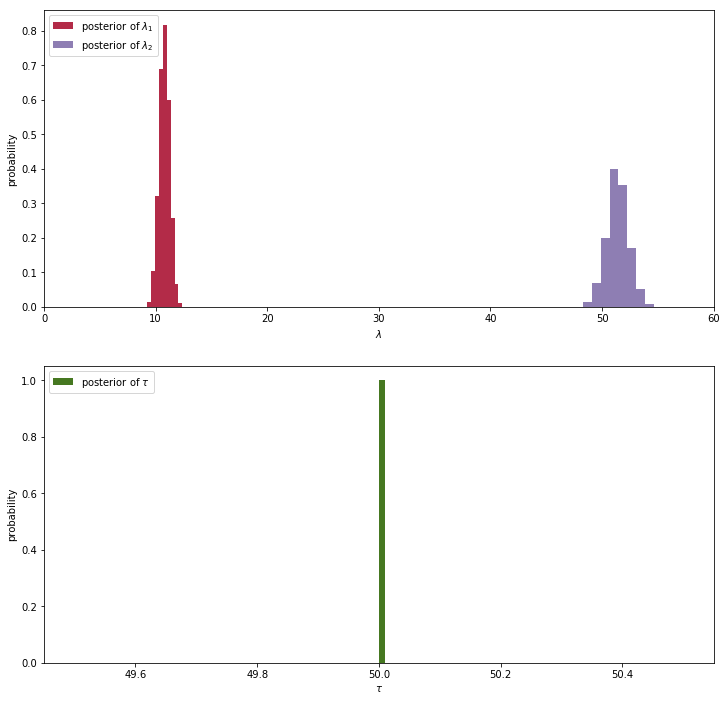

In [39]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(211)

plt.hist(lambda_1_samples, alpha=0.85,
         label="posterior of $\lambda_1$",
         color="#A60628", density=True)

plt.hist(lambda_2_samples, alpha=0.85,
         label="posterior of $\lambda_2$",
         color="#7A68A6", density=True)

plt.legend(loc="upper left")

plt.xlim([0, 60])
plt.xlabel("$\lambda$")
plt.ylabel("probability")

plt.subplot(212)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=END_B, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w)

plt.legend(loc="upper left")
plt.xlabel(r"$\tau$")
plt.ylabel("probability")

plt.show()